# Part 2 : Testing 

## Get libraries

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import torch 
from torchvision import datasets, io
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os 
import matplotlib.pyplot as plt 
import numpy as np
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules import transformer
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import pandas as pd

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the test data set

In [ ]:
targets=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [ ]:
test_data_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/test_data.pt").to(device)
test_labels_set=torch.load("/content/gdrive/MyDrive/space/Sat_tensor/test_label.pt").to(device)

display some image samples

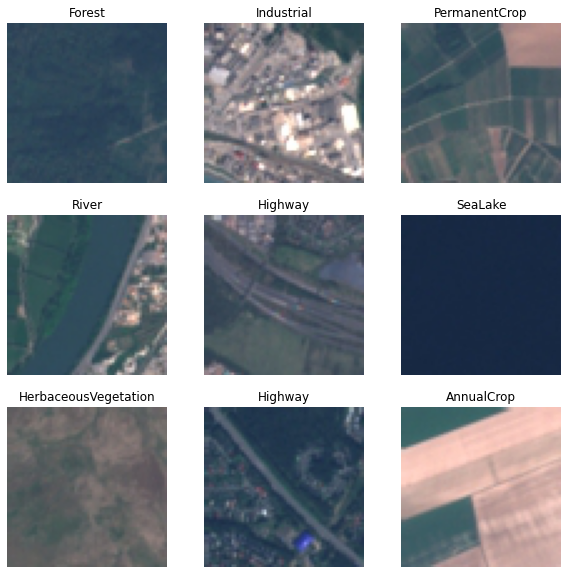

In [ ]:
sample=torch.randint(test_labels_set.shape[0],(9,))
plt.figure(figsize=(10,10))

for i,j in enumerate(sample):
  plt.subplot(3,3,i+1)
  plt.imshow(test_data_set[j].cpu().numpy().transpose(1, 2, 0).astype("uint8"))
  plt.title(targets[test_labels_set[j]])
  plt.axis("off")

## Load the model 

In [ ]:
class Trans_Vgg(nn.Module):
  def __init__(self, transformers=None) -> None:
      super().__init__()
      vgg=models.vgg16(weights='IMAGENET1K_V1')

      self.features=nn.Sequential(*vgg.features.children()).to(device)

      self.classifier=nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(64, 10),
        ).to(device)
        
      if transformers:
          self.trans=transformers

    
  def forward(self, x):

        if len(x.shape)==3:
            x=torch.unsqueeze(x, 0) # pour le cas d'une seul image 

        features=self.features(x)
        flat=torch.flatten(features,1)
        results=self.classifier(flat)
        return results

In [ ]:
model =Trans_Vgg()
model.load_state_dict(torch.load("/content/gdrive/MyDrive/space/model_vgg.pth", map_location=torch.device('cpu')))
model.eval()

Trans_Vgg(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

Evaluate the model : 

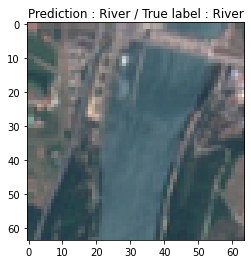

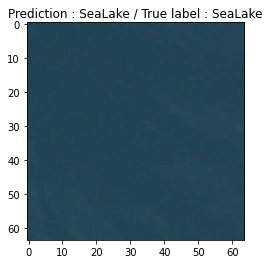

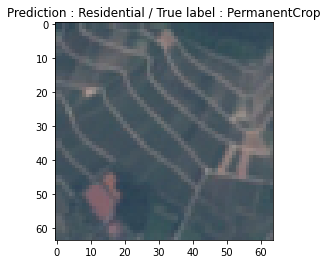

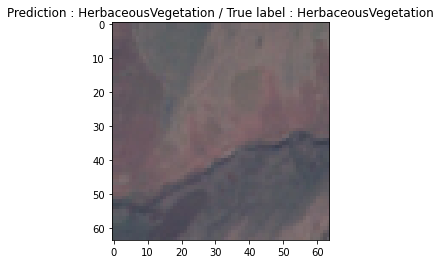

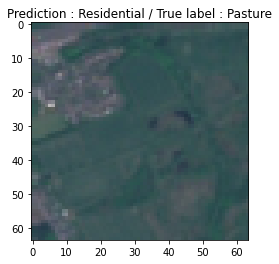

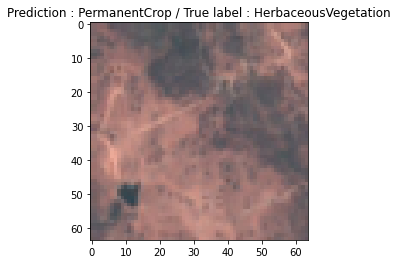

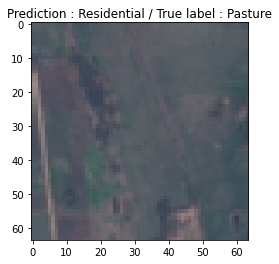

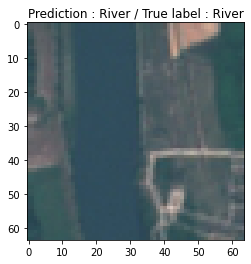

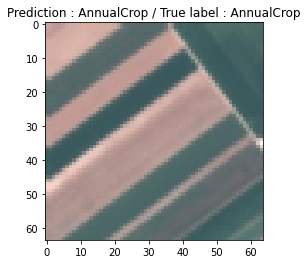

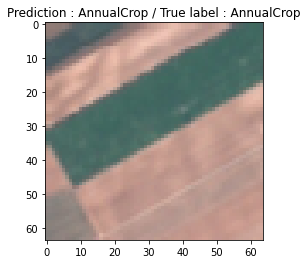

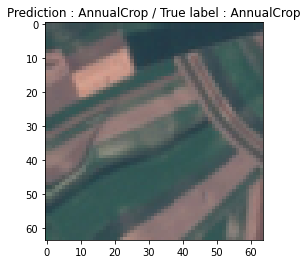

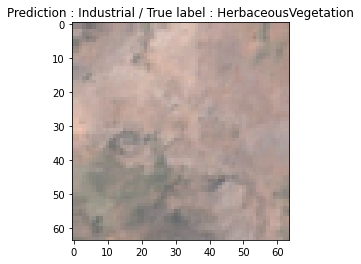

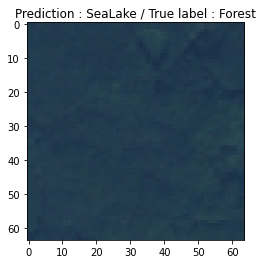

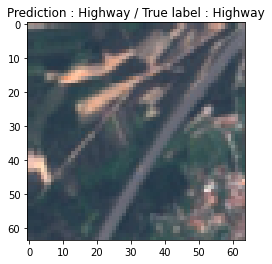

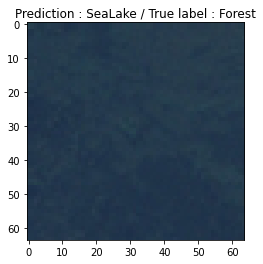

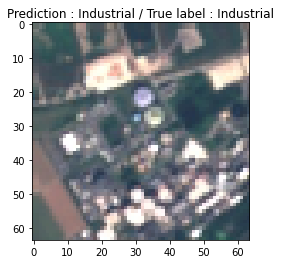

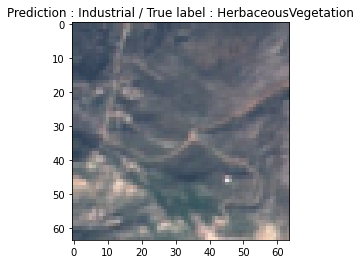

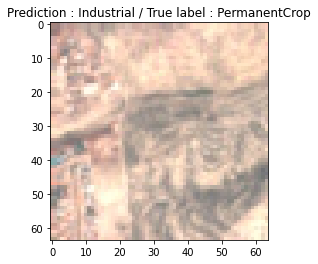

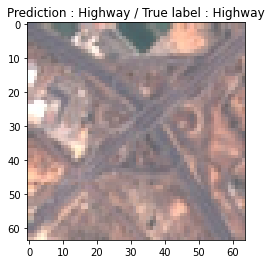

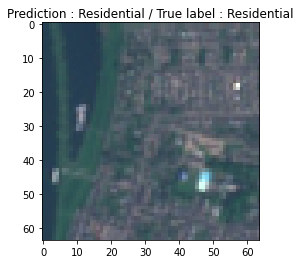

In [ ]:
# normalisation

choice_sample=torch.randint(test_labels_set.shape[0],(20,))
norm=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
                ])
data_set=test_data_set/255.0

for i in choice_sample:
  x, y= norm(data_set[i]), test_labels_set[i]
  _, pred=torch.max(model(x), 1)
  plt.figure()
  plt.imshow(test_data_set[i].cpu().numpy().transpose(1, 2, 0).astype("uint8"))
  plt.title(f"Prediction : {targets[pred]} / True label : {targets[y]}")

In [ ]:
norm=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
                ])
data_set=test_data_set/255.0
cpt_true=0

for i in range(test_labels_set.shape[0]):
  x, y= norm(data_set[i]), test_labels_set[i]
  _, pred=torch.max(model(x), 1)
  if pred.item()==y.item():
    cpt_true+=1

In [ ]:
print(f" Accuracy : {cpt_true/test_labels_set.shape[0]}")

 Accuracy : 0.6014869888475837


Confusion matrix : 

In [ ]:
choice_sample=torch.randint(test_labels_set.shape[0],(1000,))
norm=transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
                ])
data_set=test_data_set/255.0
pred_label=[]
True_label=[]
for i in choice_sample:
  x, y= norm(data_set[i]), test_labels_set[i]
  _, pred=torch.max(model(x), 1)
  True_label.append(targets[y.item()])
  pred_label.append(targets[pred.item()])

<Axes: >

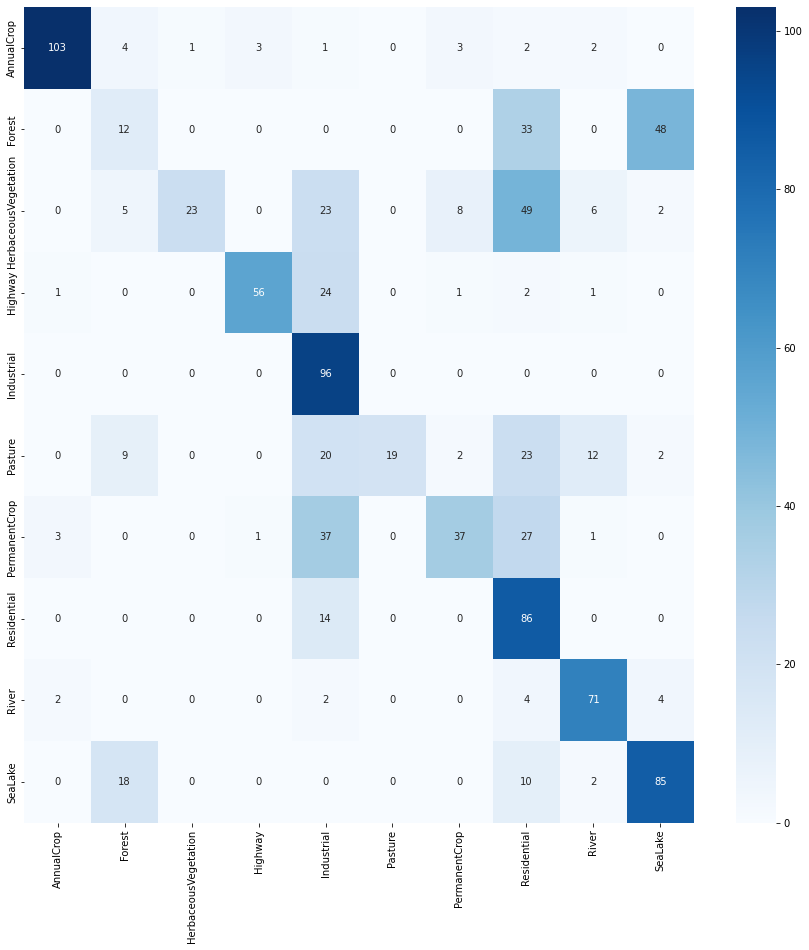

In [ ]:
plt.figure(figsize=(15,15))
conf_mat=np.array(confusion_matrix(True_label,pred_label, labels=targets))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=targets, yticklabels=targets)

The current model often confuses similar classes such as Residential and Vegetation due to their visual similarities. One solution to address this issue is to increase the diversity of the training dataset by adding more representative examples of these classes. This would enable the model to learn more distinctive features and patterns for each class, making it less likely to misclassify them. Another approach is to implement data augmentation techniques, such as random cropping, flipping, and rotating images during training. This would introduce more variability and diversity in the data, allowing the model to better differentiate between similar classes.

Due to the GPU limitations imposed by Google Colab, I was unable to test this solution. However, it has the potential to significantly enhance the model's performance.